In [1]:
# Necessary libraries and imports to complete this tutorial
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
#creating our data frames

#Information about all the players
players = pd.read_csv('Players.csv')

#The stats of each player for each year that they played, players with a * are hall of famers
seasons_stats = pd.read_csv('Seasons_Stats.csv')

#Other player data used as a cross reference in case the original data is missing values
player_data = pd.read_csv('player_data.csv')

In [3]:
players.head()


,Unnamed: 0,Player,height,weight,collage,born,birth_city,birth_state
0,0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky


In [4]:
seasons_stats.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [5]:
player_data.head()

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University


Now we want to clean up our data and make sure that any inconsistencies between players and player_data are dealt with

In [6]:
#get rid of any rows that do not have a Player name associated with them
seasons_stats = seasons_stats[~seasons_stats.Player.isnull()]
players = players[~players.Player.isnull()]

#rename Unnamed:0 column so that it looks better
players = players.rename(columns = {'Unnamed: 0':'id'})

After looking at the player_data dataset manually, we noticed there were some players that had the same name, but were different people, as a result, we have to now see just how many duplicate names there are

In [7]:
num_players = player_data.groupby('name').count()
num_players =  num_players.iloc[:,:1]
num_players = num_players.reset_index()
num_players.columns = ['Player', 'count']
num_players[num_players['count'] > 1].head()

,Player,count
314,Bill Bradley,2
420,Bob Duffy,2
494,Bobby Jones,2
505,Bobby Wilson,2
680,Cedric Henderson,2


This gurantees that there are players with repeat names, thus we will have to be careful with how we handle this dataset.

We now continue tidying the datasets

In [8]:
#get rid of unnecessary rows in seasons_stats
seasons_stats = seasons_stats.drop(['Unnamed: 0'], axis=1)
#add an id column for player_data
player_data['id'] = player_data.index

Once again looking at this dataset, we saw that the year born was innacurate for every player in the league. Year born is calculated as (year they were playing) - (age at that year). Looking at this example with Hall of Famer Kevin McHale.

In [9]:
mchale_stats = seasons_stats[seasons_stats.Player == 'Kevin McHale*']
mchale_stats['Year'].iloc[0] - mchale_stats['Age'].iloc[0] 

1958.0

A quick google search will show that Kevin McHale's birthday is 1957, thus our data is 1 year off of the correct birthyear. This issue also exists in all of the other players, thus we have to fix this.

In [10]:
#pretty simple fix, just subtract 1 from each year
seasons_stats['born'] = seasons_stats['Year'] - seasons_stats['Age'] - 1

#remove all the players in this dataset that dont have a birthyear given
players = players[~players.born.isnull()]

Now we concatenate the player and player_data datasets, so that we can have all of the players.

And thus we have handled the majority of missing values, but there is still some mistakes to correct

In [11]:
players_born = players[['Player', 'born']]

player_data = player_data[~player_data.birth_date.isnull()]

for i, row in player_data.iterrows():
    player_data.loc[i, 'born'] = float(row['birth_date'].split(',')[1])
    
    
player_data_born = player_data[['name', 'born']]
player_data_born.columns = ['Player', 'born']


born = pd.concat([players_born, player_data_born])

born = born.drop_duplicates()

born['id'] = born.index

There are only 2 mistakes in this dataset, both of which are now being manually corrected. (These are the birth years of Magic Johnson and Hakeem Olajuwon).

In [12]:
id_magic = born[born.Player == 'Magic Johnson*'].id.values[0]
id_hakeem = born[born.Player == 'Hakeem Olajuwon*'].id.values[0]
born.loc[id_magic, 'born'] = 1959
born.loc[id_hakeem, 'born'] = 1962

In [13]:
data = seasons_stats.merge(born, on=['Player', 'born'])

data = data[data.Tm != 'TOT']

Now we get the number of seasons played by each player

In [14]:
data_season =  data[['id', 'Player', 'Year']].drop_duplicates()
data_season['season']  = data_season.groupby(['id', 'Player']).cumcount() + 1

#we merge this with our original data
data = data.merge(data_season, on=['id', 'Player', 'Year'])

Now that we have our data we can look at how we can classify possible hall of famers with our data, we start with all time scoring.

In [15]:
scorers = data[['Player', 'PTS', 'id']].groupby(['id', 'Player']).sum()
scorers = scorers.reset_index()
scorers.columns = ['id', 'Player', 'PTS']
scorers = scorers.sort_values(by='PTS', ascending=False).head(20)
scorers

,id,Player,PTS
730,789,Kareem Abdul-Jabbar*,38387.0
1591,1737,Karl Malone*,36928.0
2259,2456,Kobe Bryant,33643.0
1536,1675,Michael Jordan*,32292.0
456,494,Wilt Chamberlain*,31419.0
2409,2626,Dirk Nowitzki,30260.0
2689,2944,LeBron James,28787.0
2055,2222,Shaquille O'Neal*,28596.0
1095,1185,Moses Malone*,27409.0
706,762,Elvin Hayes*,27313.0


We can see that in the top 20, based on points scored, that 12 of the players are in the hall of fame. Since this dataset was made before 2021, it is not 100% current and Kobe Bryant was also added to the Hall of Fame, so 13/20 players that are top scoring in points are also Hall of Famers.

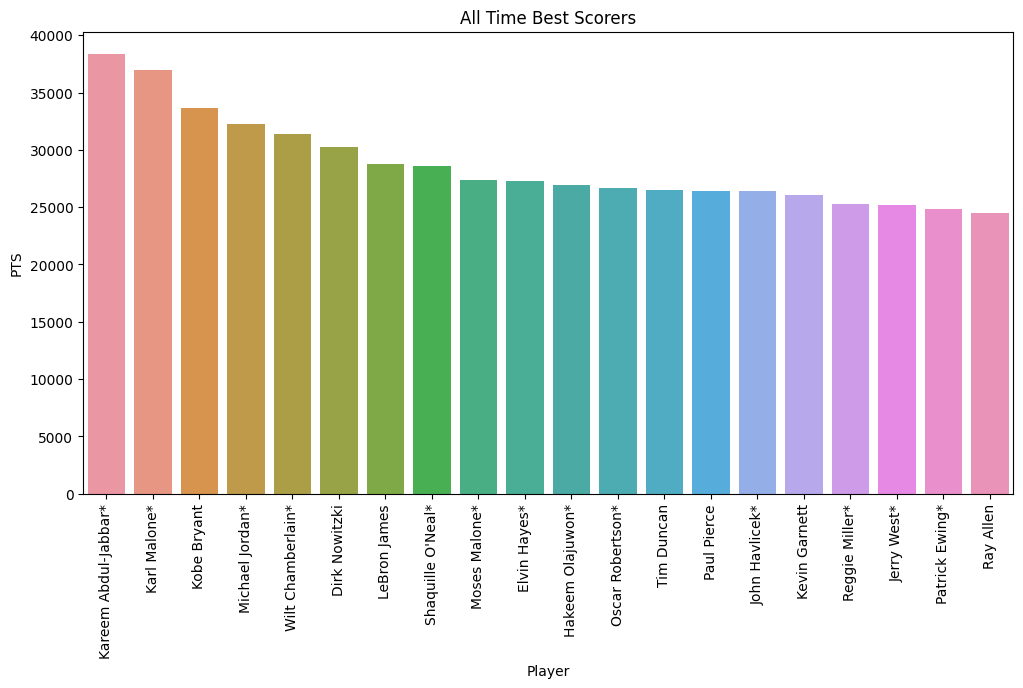

In [16]:
plt.figure(figsize=(12,6))
g = sns.barplot(x = scorers.Player, y = scorers.PTS)
g.set_xticklabels(labels = scorers.Player,  rotation=90)
plt.title('All Time Best Scorers')
plt.show()

Another way we can evaluate players is based on their PER(Player Effciency Rating)

In [17]:
# Filter players with at least 800 minutes played in the season (~ 10 min per game)
min_players = data[data.MP > 800]

per_players = min_players[['Player', 'PER', 'id']].groupby(['id', 'Player']).mean()
per_players = per_players.reset_index()
per_players = per_players.iloc[:,1:]
per_players.columns = ['Player', 'PER']
per_players = per_players.dropna()
per_players = per_players.sort_values(by='PER', ascending=False).head(20)
per_players

,Player,PER
36,George Mikan*,27.900000
861,Michael Jordan*,27.769231
1524,LeBron James,27.700000
413,Anthony Davis,26.300000
198,Wilt Chamberlain*,26.235714
1048,David Robinson*,25.669231
1599,Chris Paul,25.625000
1155,Shaquille O'Neal*,25.515789
1656,Kevin Durant,25.410000
127,Bob Pettit*,25.327273


As we can see, in the top 20, 11 of the players with high efficiency ratings are in the hall of fame. From this we can see that just scoring points alone is not a good metric for a future Hall of Famer. 

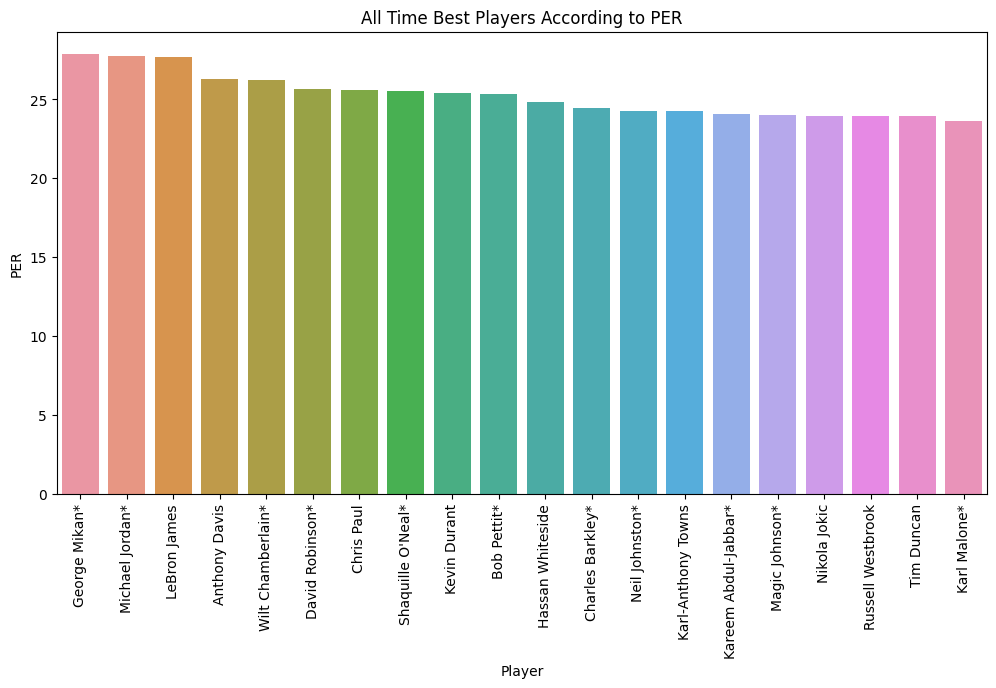

In [18]:
plt.figure(figsize=(12,6))
g = sns.barplot(x = per_players.Player, y = per_players.PER)
g.set_xticklabels(labels = per_players.Player,  rotation=90)
plt.title('All Time Best Players According to PER')
plt.show()

We can also look at points per game as another metric to evaluate players.

In [19]:
data['PPG'] = data['PTS'] / data['G']
min_players = data[data.MP > 800]

ppg_players = min_players[['Player', 'PPG', 'id']].groupby(['id', 'Player']).mean()
ppg_players = ppg_players.reset_index()
ppg_players = ppg_players.iloc[:,1:]
ppg_players.columns = ['Player', 'PPG']
ppg_players = ppg_players.dropna()
ppg_players = ppg_players.sort_values(by='PPG', ascending=False).head(20)
ppg_players

,Player,PPG
198,Wilt Chamberlain*,30.592828
861,Michael Jordan*,30.163303
176,Elgin Baylor*,27.673139
1524,LeBron James,27.121076
1656,Kevin Durant,27.029466
1281,Allen Iverson*,26.875923
223,Jerry West*,26.741316
561,George Gervin*,26.180839
127,Bob Pettit*,26.177270
221,Oscar Robertson*,25.526368


We can see from this that 16/20 of the players in this list had very high points per game. This metric seems to have a very high indication for players that will get into the hall of fame or not.

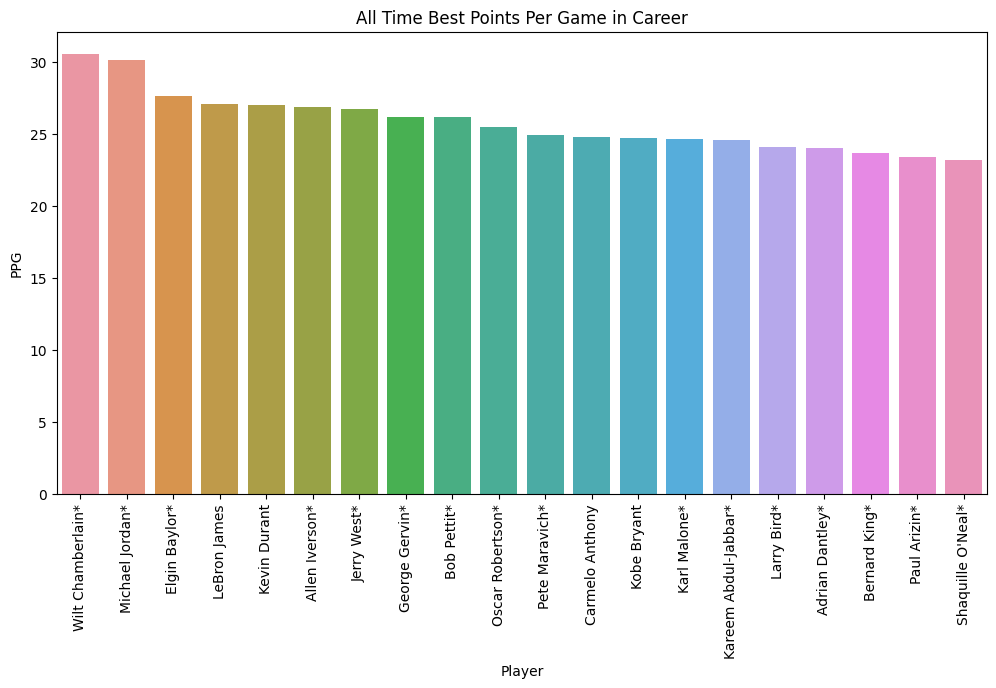

In [20]:
plt.figure(figsize=(12,6))
g = sns.barplot(x = ppg_players.Player, y = ppg_players.PPG)
g.set_xticklabels(labels = ppg_players.Player,  rotation=90)
plt.title('All Time Best Points Per Game in Career')
plt.show()

Now we do a linear regression to predict future hall of famers. But first we will need to do some auxillary steps to ensure higher accuracy.

In [21]:
#Extra stats to look at in data
data['APG'] = data['AST'] / data['G']
data['RPG'] = data['TRB'] / data['G']
data['SPG'] = data['STL'] / data['G']
data['BPG'] = data['BLK'] / data['G']

# Adding mvps in case this also increases chance of being a Hall of Famer
mvp_players = {'Bob Pettit*': [1956, 1959],
                  'Bob Cousy*': [1957],
                  'Bill Russell*': [1958, 1961, 1962, 1963, 1965],
                  'Wilt Chamberlain*': [1960, 1966, 1967, 1968],
                  'Oscar Robertson*': [1964],
                  'Wes Unseld*': [1969],
                  'Willis Reed*': [1970],
                  'Kareem Abdul-Jabbar*': [1971, 1972, 1974, 1976, 1977, 1980],
                  'Dave Cowens*': [1973],
                  'Bob McAdoo*': [1975],
                  'Bill Walton*': [1978],
                  'Moses Malone*': [1979, 1982, 1983],
                  'Julius Erving*': [1981],
                  'Larry Bird*': [1984, 1985, 1986],
                  'Magic Johnson*': [1987, 1989, 1990],
                  'Michael Jordan*': [1988, 1991, 1992, 1996, 1998],
                  'Charles Barkley*': [1993],
                  'Hakeem Olajuwon*': [1994],
                  'David Robinson*': [1995],
                  'Karl Malone*': [1997, 1999],
                  'Shaquille O\'Neal*': [2000],
                  'Allen Iverson*': [2001],
                  'Tim Duncan': [2002, 2003],
                  'Kevin Garnett': [2004],
                  'Steve Nash': [2005, 2006],
                  'Dirk Nowitzki': [2007],
                  'Kobe Bryant': [2008],
                  'LeBron James': [2009, 2010, 2012, 2013],
                  'Derrick Rose': [2011],
                  'Kevin Durant': [2014],
                  'Stephen Curry': [2015, 2016],
                  'Russell Westbrook': [2017],
                  'James Harden': [2018]}

data['MVP'] = 0
for i, row in data.iterrows():  
    for k, v in mvp_players.items():
        for year in v:
            if row['Player'] != k:
                break
            elif(row['Year'] == year) & (row['Player'] == k):
                data.loc[i, 'MVP'] = 1
                break



In [22]:
# Adding nba champions in case this also increases chance of being a Hall of Famer
teams_champions = {'BOS': [1957, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1968, 1969, 1974, 1976, 1981, 1984, 1986, 2008],
                  'LAL': [1972, 1980, 1982, 1985, 1987, 1988, 2000, 2001, 2002, 2009, 2010],
                  'MNL': [1949, 1950, 1952, 1953, 1954],
                  'CHI': [1991, 1992, 1993, 1996, 1997, 1998],
                  'GSW': [1975, 2015, 2017, 2018],
                  'PHW': [1947, 1956],
                  'SAS': [1999, 2003, 2005, 2007, 2014],
                  'DET': [1989, 1990, 2004],
                  'MIA': [2006, 2012, 2013],
                  'PHI': [1967, 1983],
                  'SYR': [1955],
                  'HOU': [1994, 1995],
                  'NYK': [1970, 1973],
                  'STL': [1958],
                  'BLB': [1948],
                  'CLE': [2016],
                  'DAL': [2011],
                  'MIL': [1971],
                  'SEA': [1979],
                  'POR': [1977],
                  'ROC': [1951],
                  'WSB': [1978]}

data['Champion'] = 0
for i, row in data.iterrows():  
    for k, v in teams_champions.items():
        for year in v:
            if row['Tm'] != k:
                break
            elif(row['Year'] == year) & (row['Tm'] == k):
                data.loc[i, 'Champion'] = 1
                break

In [23]:
# Filter players with at least 800 min in a season
hall_of_fame = data[data.MP > 800]

list_famers = []
for i, row in hall_of_fame.iterrows():
    if '*' in row['Player']:
        list_famers.append(row['Player'])
list_famers = list(set(list_famers))

In [24]:
#Create a function so that we can make a column in data, so that it is easier to if a player is in the Hall of Fame
def is_hof(x):
    if '*' in x:
        return 1
    else:
        return 0
    
hall_of_fame['HOF'] = hall_of_fame['Player'].apply(is_hof)

C:\Users\pggup\AppData\Local\Temp\ipykernel_25308\2860007248.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hall_of_fame['HOF'] = hall_of_fame['Player'].apply(is_hof)


In [25]:
# Season 1973 - 1974 : start to count Steals, Blocks and BPM
#so anything before that is discounted
hall_of_fame = hall_of_fame[hall_of_fame.Year >= 1974]

mvps = data[['id', 'Player', 'MVP']]
mvps['Nb_MVP'] = mvps.groupby('id').cumsum()
mvps = mvps.groupby(['id', 'Player'], sort=False)['Nb_MVP'].max().reset_index()
mvps.sort_values(by='Nb_MVP', ascending=False).head(10)

C:\Users\pggup\AppData\Local\Temp\ipykernel_25308\3625778985.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.cumsum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mvps['Nb_MVP'] = mvps.groupby('id').cumsum()
C:\Users\pggup\AppData\Local\Temp\ipykernel_25308\3625778985.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mvps['Nb_MVP'] = mvps.groupby('id').cumsum()


,id,Player,Nb_MVP
707,789,Kareem Abdul-Jabbar*,6
1509,1675,Michael Jordan*,5
386,438,Bill Russell*,5
2681,2944,LeBron James,4
2350,494,Gerald Brown,4
437,494,Wilt Chamberlain*,4
1061,1185,Moses Malone*,3
1222,1366,Magic Johnson*,3
1199,1341,Larry Bird*,3
1566,1737,Karl Malone*,2


In [26]:
champions = data[['id', 'Player', 'Champion']]
champions['Total_Champion'] = champions.groupby('id').cumsum()
champions = champions.groupby(['id', 'Player'], sort=False)['Total_Champion'].max().reset_index()
champions.sort_values(by='Total_Champion', ascending=False).head(10)

C:\Users\pggup\AppData\Local\Temp\ipykernel_25308\2024852811.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.cumsum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  champions['Total_Champion'] = champions.groupby('id').cumsum()
C:\Users\pggup\AppData\Local\Temp\ipykernel_25308\2024852811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  champions['Total_Champion'] = champions.groupby('id').cumsum()


,id,Player,Total_Champion
386,438,Bill Russell*,11
399,453,Sam Jones*,10
424,480,K.C. Jones*,8
466,526,Tom Sanders*,8
514,578,John Havlicek*,8
377,427,Tom Heinsohn*,8
1989,2203,Robert Horry,7
356,405,Jim Loscutoff,7
335,380,Frank Ramsey*,7
206,233,Bob Cousy*,6


In [27]:
nb_seasons = data_season[['id', 'Player', 'season']]
nb_seasons = nb_seasons.groupby(['id', 'Player'], sort=False)['season'].max().reset_index()
nb_seasons.sort_values(by='season', ascending=False).head(10)

,id,Player,season
1536,4426,Kevin Willis,21
1070,1195,Robert Parish*,21
2170,2401,Kevin Garnett,21
2224,2456,Kobe Bryant,20
707,789,Kareem Abdul-Jabbar*,20
1575,1747,Charles Oakley,19
1116,1248,James Edwards,19
1566,1737,Karl Malone*,19
2388,2630,Paul Pierce,19
1061,1185,Moses Malone*,19


In [28]:
last_season = hall_of_fame[['id', 'Player', 'Year']]
last_season = last_season.groupby(['id', 'Player'], sort=False)['Year'].max().reset_index()
last_season.columns = ['id', 'Player', 'Last_Season']

total_points = data[['Player', 'PTS', 'id']].groupby(['id', 'Player']).sum()
total_points = total_points.reset_index()
total_points.columns = ['id', 'Player', 'Total_PTS']

In [29]:
career = hall_of_fame.groupby(['id', 'Player']).mean()
career = career.reset_index()
career.head()

C:\Users\pggup\AppData\Local\Temp\ipykernel_25308\106354038.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  career = hall_of_fame.groupby(['id', 'Player']).mean()


,id,Player,Year,Age,G,GS,MP,PER,TS%,3PAr,...,born,season,PPG,APG,RPG,SPG,BPG,MVP,Champion,HOF
0,3,Mahmoud Abdul-Rauf,1994.000000,24.000000,73.428571,48.000000,2087.428571,15.242857,0.507857,0.179714,...,1969.0,4.000000,15.777782,3.880602,2.002227,0.907202,0.084110,0.0,0.000000,0.0
1,44,Courtney Alexander,2002.000000,24.000000,49.666667,17.666667,1198.333333,12.366667,0.499667,0.080667,...,1977.0,2.000000,11.563592,1.417068,2.464566,0.722924,0.096661,0.0,0.000000,0.0
2,58,Ray Allen,2005.368421,29.368421,68.421053,60.473684,2439.157895,18.526316,0.581474,0.402316,...,1975.0,9.368421,19.124945,3.452787,4.118728,1.137763,0.185133,0.0,0.105263,0.0
3,74,David Andersen,2010.000000,29.000000,63.000000,0.000000,891.000000,12.100000,0.497000,0.229000,...,1980.0,1.000000,5.825397,0.698413,3.301587,0.238095,0.190476,0.0,0.000000,0.0
4,146,D.J. Augustin,2012.625000,24.625000,68.875000,23.625000,1681.625000,13.837500,0.537250,0.435625,...,1987.0,4.625000,10.214707,4.143085,1.836157,0.607843,0.035776,0.0,0.000000,0.0


In [30]:
career_num = career[['id', 'Player', 'PER', 'TS%', 'OWS', 'DWS', 
                     'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 
                     'FG%', '3P%', '2P%', 'eFG%', 'FT%', 
                     'PPG', 'APG', 'RPG', 'SPG', 'BPG', 'HOF']]

career_num = career_num.merge(mvps, on=['id', 'Player'])
career_num = career_num.merge(champions, on=['id', 'Player'])
career_num = career_num.merge(nb_seasons, on=['id', 'Player'])
career_num = career_num.merge(last_season, on=['id', 'Player'])
career_num = career_num.merge(total_points, on=['id', 'Player'])

career_num.head()

,id,Player,PER,TS%,OWS,DWS,WS,WS/48,OBPM,DBPM,...,APG,RPG,SPG,BPG,HOF,Nb_MVP,Total_Champion,season,Last_Season,Total_PTS
0,3,Mahmoud Abdul-Rauf,15.242857,0.507857,2.385714,1.171429,3.528571,0.072714,0.800000,-3.057143,...,3.880602,2.002227,0.907202,0.084110,0.0,0,0,9,1997.0,8553.0
1,44,Courtney Alexander,12.366667,0.499667,0.866667,0.566667,1.400000,0.056000,-1.333333,-2.266667,...,1.417068,2.464566,0.722924,0.096661,0.0,0,0,3,2003.0,1690.0
2,58,Ray Allen,18.526316,0.581474,5.873684,1.757895,7.642105,0.149263,4.205263,-1.247368,...,3.452787,4.118728,1.137763,0.185133,0.0,0,2,18,2014.0,24505.0
3,74,David Andersen,12.100000,0.497000,0.400000,0.900000,1.300000,0.070000,-2.500000,-1.300000,...,0.698413,3.301587,0.238095,0.190476,0.0,0,0,2,2010.0,501.0
4,146,D.J. Augustin,13.837500,0.537250,2.300000,1.162500,3.437500,0.094500,0.812500,-2.625000,...,4.143085,1.836157,0.607843,0.035776,0.0,0,0,9,2017.0,6214.0


In [31]:
career_num[career_num.HOF ==1]['season'].describe()

count    74.000000
mean     13.067568
std       3.601107
min       3.000000
25%      11.000000
50%      13.000000
75%      15.000000
max      21.000000
Name: season, dtype: float64

Now that we have the data for Hall of Famers, we can finally use this and compare it to non-Hall of Famers, in order to predict future Hall of Famers.

In [32]:
career_num = career_num.fillna(0)

career_num = career_num.drop(['Player'], axis=1)

In [33]:
# Looking at the features correlations with HOF
career_num.corr()['HOF'].sort_values(ascending=False)

HOF               1.000000
Total_PTS         0.471363
WS                0.389546
PPG               0.365606
OWS               0.354728
PER               0.323333
DWS               0.315797
Nb_MVP            0.315343
BPM               0.290873
WS/48             0.285238
Total_Champion    0.280929
OBPM              0.277936
season            0.240575
RPG               0.234286
SPG               0.204839
APG               0.202173
BPG               0.166891
FG%               0.135673
TS%               0.120102
2P%               0.095232
DBPM              0.088586
FT%               0.074549
eFG%              0.059544
3P%              -0.089724
Last_Season      -0.172186
id               -0.224112
Name: HOF, dtype: float64

From this we can see that our initially guesses were correct and that Total_Points, PPG, and PER were a significant part of calculating if you were a Hall of Famer, but Offensive Win Sharing  and Defensive Win Sharing are also values that have a large effect on seeing if you are a Hall of Famer.

In [34]:
from sklearn import tree
from sklearn.model_selection import train_test_split
# train : older players who stop playing 20+ years ago (last data year is 2017 so 1997)
train = career_num[(career_num.Last_Season <= 1997) | (career_num.HOF == 1)]
test = career_num[(career_num.Last_Season > 1997) & (career_num.HOF == 0)]

In [35]:
X_train = train.drop('HOF', axis=1)
y_train = train['HOF']
X_test = test.drop('HOF', axis=1)

[Text(0.6883650519031141, 0.9545454545454546, 'X[24] <= 14035.5\ngini = 0.177\nsamples = 753\nvalue = [679, 74]'),
 Text(0.5289792387543253, 0.8636363636363636, 'X[4] <= 3.924\ngini = 0.057\nsamples = 680\nvalue = [660, 20]'),
 Text(0.41782006920415227, 0.7727272727272727, 'X[1] <= 19.08\ngini = 0.041\nsamples = 672\nvalue = [658, 14]'),
 Text(0.27854671280276816, 0.6818181818181818, 'X[0] <= 735.5\ngini = 0.03\nsamples = 666\nvalue = [656, 10]'),
 Text(0.08304498269896193, 0.5909090909090909, 'X[0] <= 719.0\ngini = 0.264\nsamples = 32\nvalue = [27, 5]'),
 Text(0.05536332179930796, 0.5, 'X[18] <= 0.337\ngini = 0.18\nsamples = 30\nvalue = [27, 3]'),
 Text(0.02768166089965398, 0.4090909090909091, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.08304498269896193, 0.4090909090909091, 'X[9] <= -2.286\ngini = 0.128\nsamples = 29\nvalue = [27, 2]'),
 Text(0.05536332179930796, 0.3181818181818182, 'X[19] <= 0.202\ngini = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(0.02768166089965398, 0.227

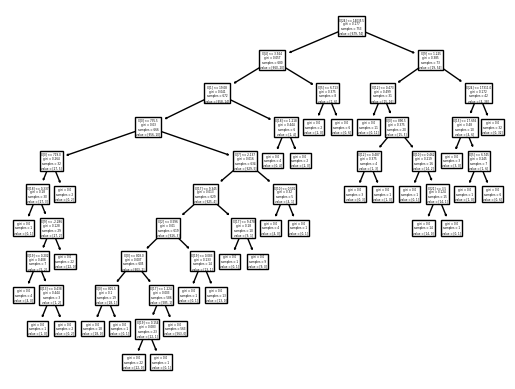

In [36]:
# Decision Tree

dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
dt.score(X_train, y_train)
acc_dt = round(dt.score(X_train, y_train) * 100, 2)
acc_dt

tree.plot_tree(dt)

In the Code above, we use sklearns tree in order to train a decision tree. As you can see above, the tree is fairly large due to the amount of variables it has to consider in order to get to its result.

In [37]:
pred_proba = dt.predict_proba(X_test)
pred_proba

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

For the code below, we will now be predicting who will and who will not be in the hall of fame and adding it to the data frame so that we can easily see and understand the results.

In [38]:
y_pred_proba = []
for i in enumerate(pred_proba):
    y_pred_proba.append(i[1][1])
y_pred_proba = np.asarray(y_pred_proba)

results_hof = pd.DataFrame({
    "id": test["id"],
    "HOF": y_pred_proba
    })

In [39]:
career_player = career[['id', 'Player']]
results_hof = career_player.merge(results_hof, on='id')

results_hof = results_hof.sort_values(by='HOF', ascending=False)
results_hof = results_hof.head(20)
results_hof

,id,Player,HOF
606,3096,Chris Paul,1.0
653,3188,Brandon Roy,1.0
603,3088,Sean May,1.0
196,2277,Allan Houston,1.0
73,1925,Steve Kerr,1.0
430,2758,Michael Redd,1.0
973,3824,Karl-Anthony Towns,1.0
326,2586,Mike Bibby,1.0
241,2399,Michael Finley,1.0
811,3491,Kawhi Leonard,1.0


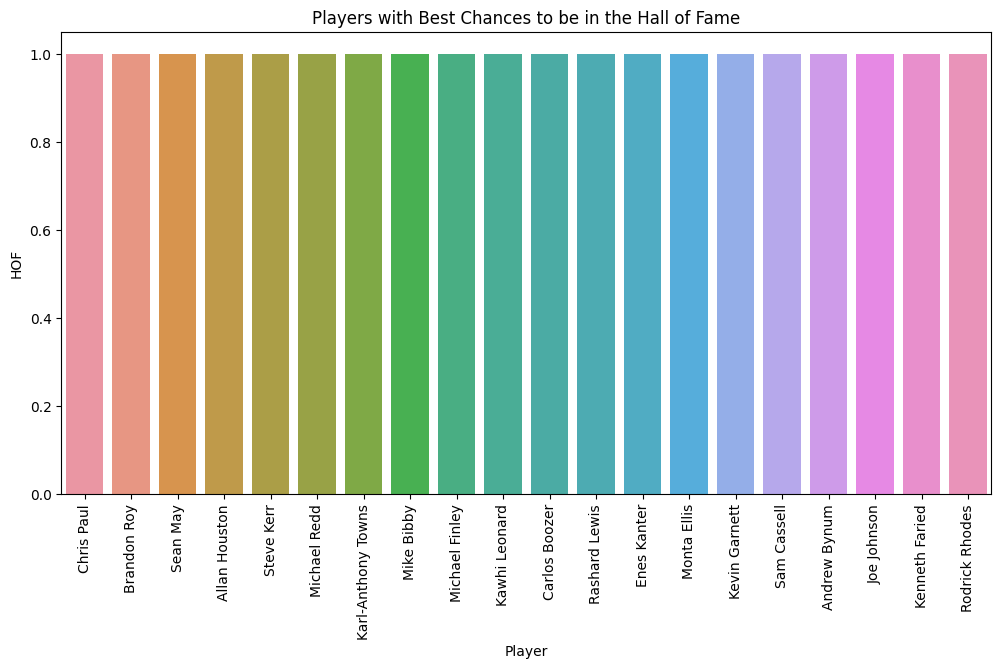

In [40]:
plt.figure(figsize=(12,6))
g = sns.barplot(x = results_hof.Player, y = results_hof.HOF)
g.set_xticklabels(labels = results_hof.Player,  rotation=90)
plt.title('Players to be in the Hall of Fame')
plt.show()

Looking at our end results for the decision tree, we can see that while we do get a result for who will and who will not be in the Hall of Fame, these results don't give us anything that can be used beyond just 'yes' or 'no'. With the other classifiers, we get a percentage chance for Hall of Fame status, which is a much more useful metric to evaluate who potential Hall of Famers. Simply know whether or not some can make it to the Hall of Fame will not help a company choose a potential player to sponsor, whereas knowing a player has 92% chance to make it to the Hall of Fame definitely will help a company choose. This goes to show that not all classifiers are going to provide results that matter for all types of problems. In this case, while a decision tree does the job, it just doesn't perform at the same level as the three other algorithms, because there's no way to really compare the results from the Decision Tree.

For further reading into why Decision Trees are not optimal, the link:( https://careerfoundry.com/en/blog/data-analytics/what-is-a-decision-tree/#:~:text=Disadvantages%20of%20decision%20trees,-Overfitting%20(where%20a&text=They%20are%20not%20well%2Dsuited,path%20includes%20many%20chance%20variables. ), was very informative for me when I was trying to interpret the results of the decision tree. 